In [83]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import scipy
import sklearn as skl
import warnings
warnings.filterwarnings("ignore")

from scipy.cluster import hierarchy as hc

The goal is to predict the sale price of a particular piece of heavy equiment at auction based on it's usage, equipment type, and configuration. The data is sourced from auction result postings and includes information on usage and equipment configurations."

In [86]:
train_df=pd.read_csv('Train.csv',parse_dates=["saledate"])

In [89]:
print(train_df.head())

   SalesID  SalePrice  MachineID  ModelID  datasource  auctioneerID  YearMade  \
0  1139246      66000     999089     3157         121           3.0      2004   
1  1139248      57000     117657       77         121           3.0      1996   
2  1139249      10000     434808     7009         121           3.0      2001   
3  1139251      38500    1026470      332         121           3.0      2001   
4  1139253      11000    1057373    17311         121           3.0      2007   

   MachineHoursCurrentMeter UsageBand   saledate  ... Undercarriage_Pad_Width  \
0                      68.0       Low 2006-11-16  ...                     NaN   
1                    4640.0       Low 2004-03-26  ...                     NaN   
2                    2838.0      High 2004-02-26  ...                     NaN   
3                    3486.0      High 2011-05-19  ...                     NaN   
4                     722.0    Medium 2009-07-23  ...                     NaN   

  Stick_Length Thumb Patte

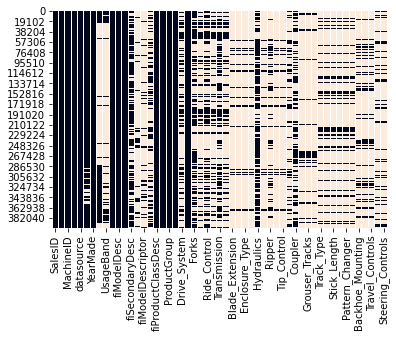

In [90]:
sns.heatmap(train_df.isnull(), cbar=False) #no nulls/nans/blank

The key fields are in train.csv are:

SalesID: the unique identifier of the sale <br/>
MachineID: the unique identifier of a machine. A machine can be sold multiple times<br/>
saleprice: what the machine sold for at auction (only provided in train.csv)<br/>
saledate: the date of the sale<br/>

# processing the data

In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   401125 non-null  int64         
 1   SalePrice                 401125 non-null  int64         
 2   MachineID                 401125 non-null  int64         
 3   ModelID                   401125 non-null  int64         
 4   datasource                401125 non-null  int64         
 5   auctioneerID              380989 non-null  float64       
 6   YearMade                  401125 non-null  int64         
 7   MachineHoursCurrentMeter  142765 non-null  float64       
 8   UsageBand                 69639 non-null   object        
 9   saledate                  401125 non-null  datetime64[ns]
 10  fiModelDesc               401125 non-null  object        
 11  fiBaseModel               401125 non-null  object        
 12  fi

In [19]:
df=train_df
df.sort_values(by = ['saledate'],inplace = True,ascending = True)
df.saledate

205615   1989-01-17
92803    1989-01-31
98346    1989-01-31
169297   1989-01-31
274835   1989-01-31
            ...    
393123   2011-12-30
397987   2011-12-30
392664   2011-12-30
400458   2011-12-30
400217   2011-12-30
Name: saledate, Length: 401125, dtype: datetime64[ns]

In [20]:
df['SaleYear'] = df.saledate.dt.year
df['SaleMonth'] = df.saledate.dt.month
df['SaleDay'] = df.saledate.dt.day
df['SaleDayOfWeek'] = df.saledate.dt.dayofweek
df['SaleDayOfyear'] = df.saledate.dt.dayofyear

In [24]:
df = df.drop('saledate',axis = 1)

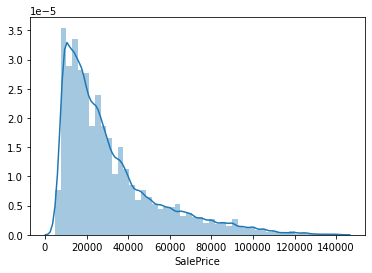

In [25]:
sns.distplot(df.SalePrice)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401125 entries, 205615 to 400217
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   401125 non-null  int64  
 1   SalePrice                 401125 non-null  int64  
 2   MachineID                 401125 non-null  int64  
 3   ModelID                   401125 non-null  int64  
 4   datasource                401125 non-null  int64  
 5   auctioneerID              380989 non-null  float64
 6   YearMade                  401125 non-null  int64  
 7   MachineHoursCurrentMeter  142765 non-null  float64
 8   UsageBand                 69639 non-null   object 
 9   fiModelDesc               401125 non-null  object 
 10  fiBaseModel               401125 non-null  object 
 11  fiSecondaryDesc           263934 non-null  object 
 12  fiModelSeries             56908 non-null   object 
 13  fiModelDescriptor         71919 non-nul

dropping columns with many unique categories

In [27]:
max_cardinality = 100
high_cardinality = [col for col in df.select_dtypes(exclude=np.number)
                   if df[col].nunique() > max_cardinality]
df = df.drop(columns=high_cardinality)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401125 entries, 205615 to 400217
Data columns (total 52 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   401125 non-null  int64  
 1   SalePrice                 401125 non-null  int64  
 2   MachineID                 401125 non-null  int64  
 3   ModelID                   401125 non-null  int64  
 4   datasource                401125 non-null  int64  
 5   auctioneerID              380989 non-null  float64
 6   YearMade                  401125 non-null  int64  
 7   MachineHoursCurrentMeter  142765 non-null  float64
 8   UsageBand                 69639 non-null   object 
 9   ProductSize               190350 non-null  object 
 10  fiProductClassDesc        401125 non-null  object 
 11  state                     401125 non-null  object 
 12  ProductGroup              401125 non-null  object 
 13  ProductGroupDesc          401125 non-nu

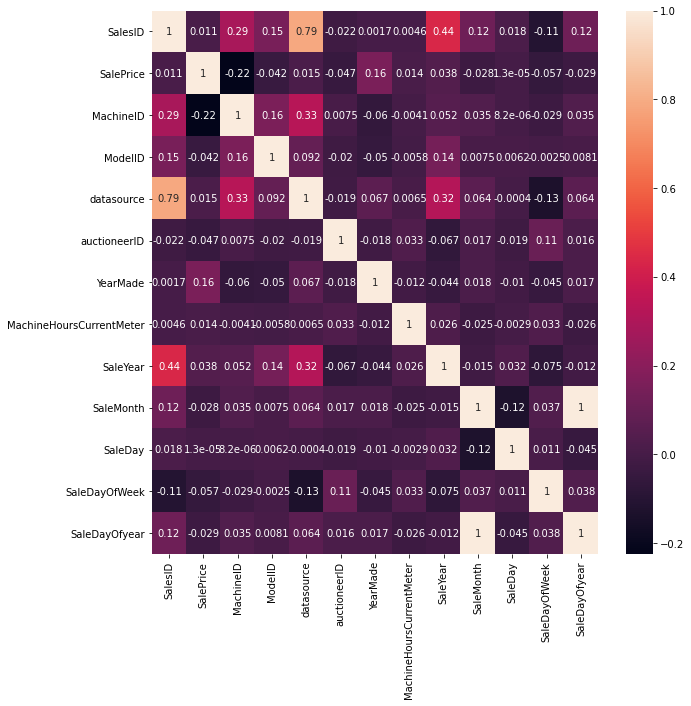

In [28]:
fig=plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),annot=True)

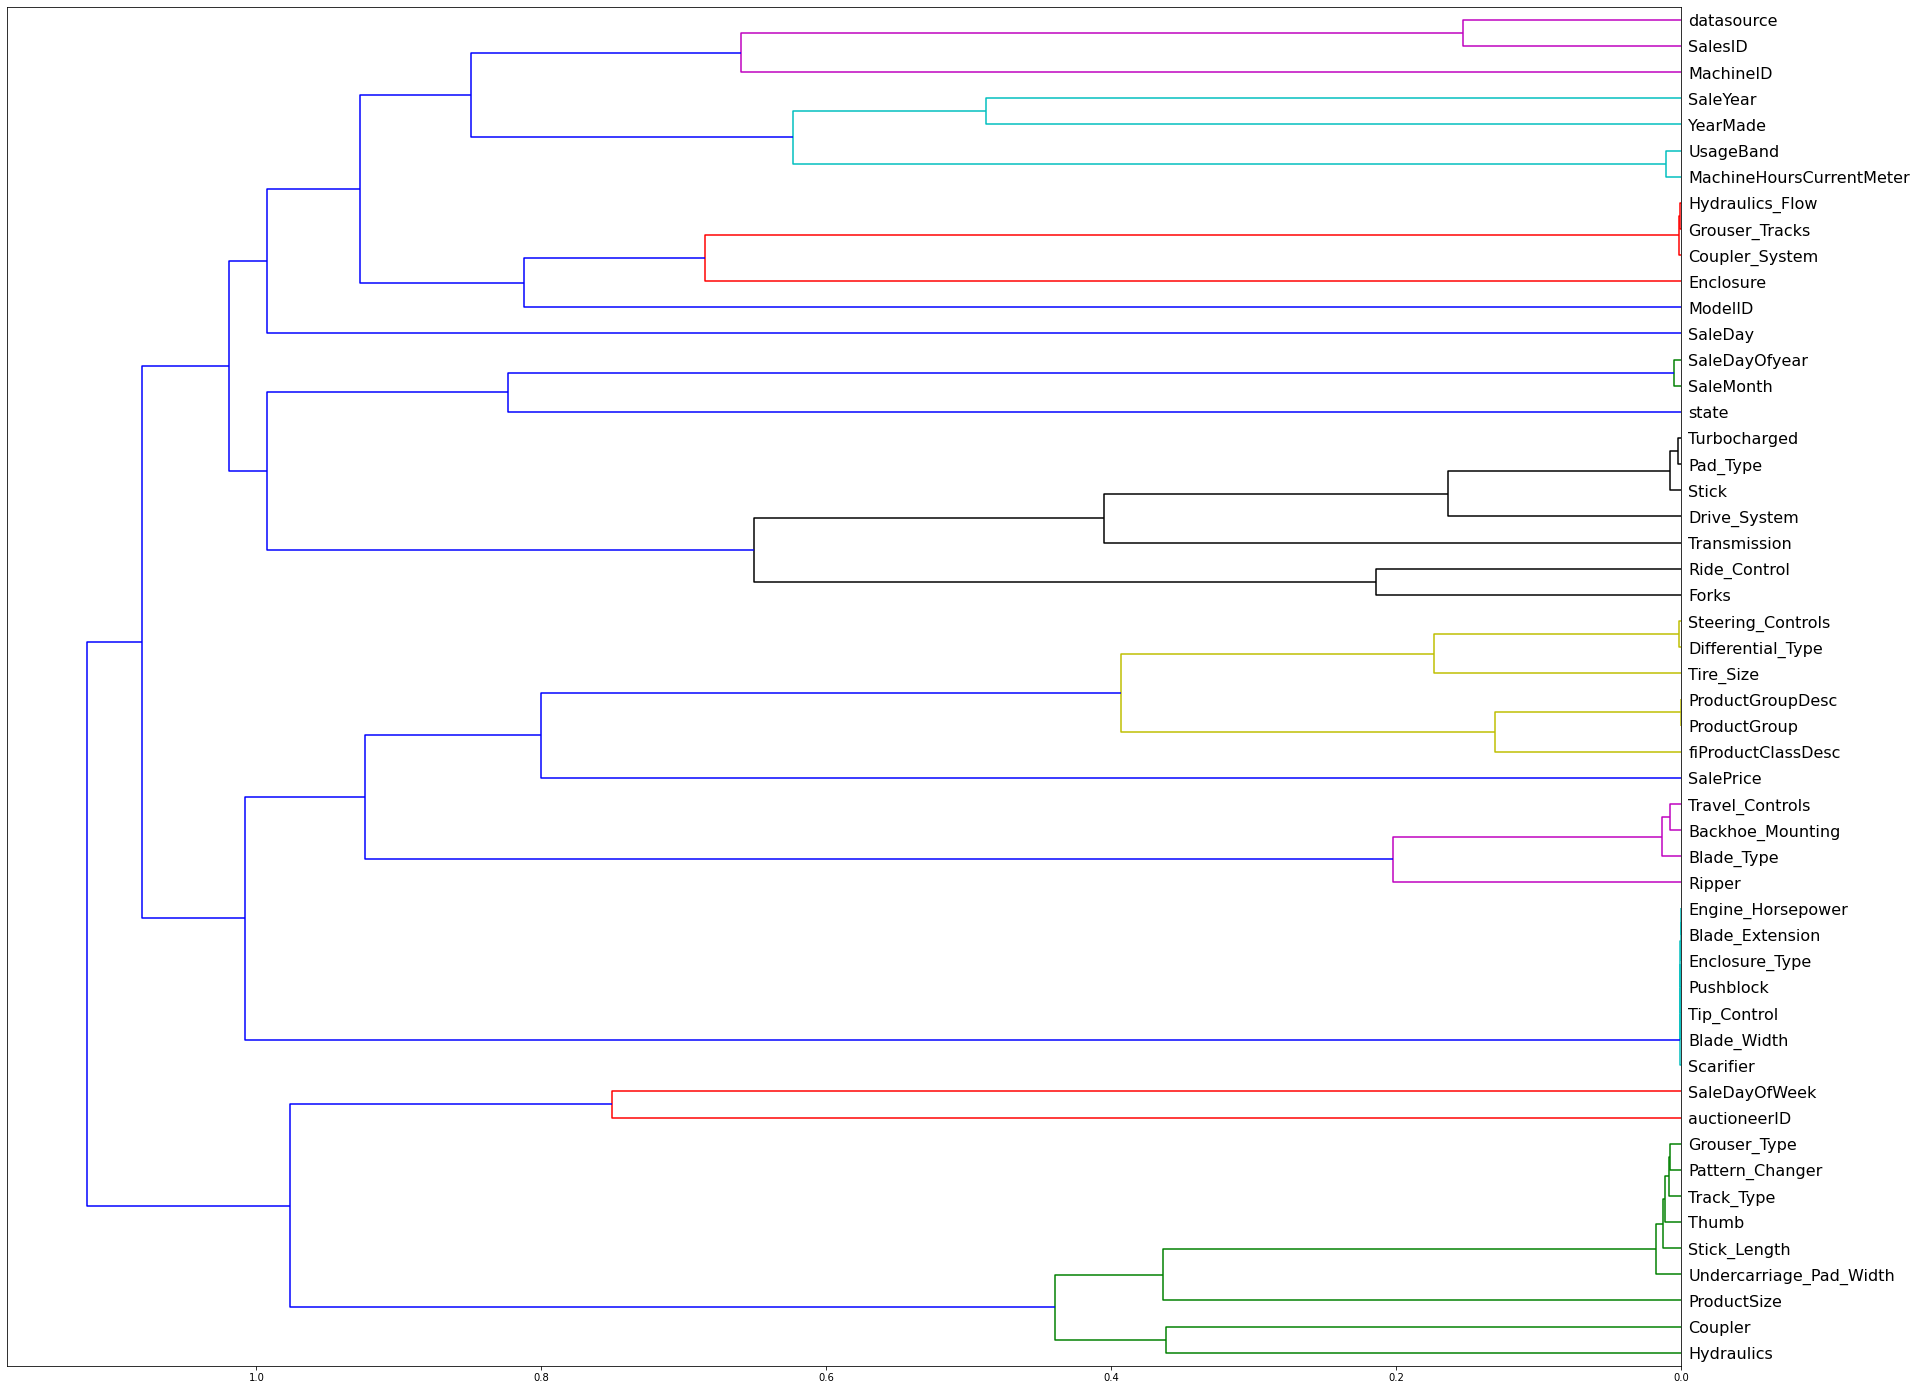

In [82]:

import scipy
corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(30,25))
dendrogram = hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=16)
plt.show()

# Data Preprocessing<br/>
Changing the data format to numeric type<br/>
Dealing with missing values

In [29]:
for label, content in df.items():
    if pd.api.types.is_string_dtype(content):
        df[label] = content.astype('category').cat.as_ordered()
        df[label] = pd.Categorical(content).codes+1

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401125 entries, 205615 to 400217
Data columns (total 52 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   401125 non-null  int64  
 1   SalePrice                 401125 non-null  int64  
 2   MachineID                 401125 non-null  int64  
 3   ModelID                   401125 non-null  int64  
 4   datasource                401125 non-null  int64  
 5   auctioneerID              380989 non-null  float64
 6   YearMade                  401125 non-null  int64  
 7   MachineHoursCurrentMeter  142765 non-null  float64
 8   UsageBand                 401125 non-null  int8   
 9   ProductSize               401125 non-null  int8   
 10  fiProductClassDesc        401125 non-null  int8   
 11  state                     401125 non-null  int8   
 12  ProductGroup              401125 non-null  int8   
 13  ProductGroupDesc          401125 non-nu

# Fill NA with Median

In [31]:
for label,content in df.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isna(content).sum():
            df[label] = content.fillna(content.median())

In [32]:
df.isna().sum()

SalesID                     0
SalePrice                   0
MachineID                   0
ModelID                     0
datasource                  0
auctioneerID                0
YearMade                    0
MachineHoursCurrentMeter    0
UsageBand                   0
ProductSize                 0
fiProductClassDesc          0
state                       0
ProductGroup                0
ProductGroupDesc            0
Drive_System                0
Enclosure                   0
Forks                       0
Pad_Type                    0
Ride_Control                0
Stick                       0
Transmission                0
Turbocharged                0
Blade_Extension             0
Blade_Width                 0
Enclosure_Type              0
Engine_Horsepower           0
Hydraulics                  0
Pushblock                   0
Ripper                      0
Scarifier                   0
Tip_Control                 0
Tire_Size                   0
Coupler                     0
Coupler_Sy

# Splitting the data

In [33]:
X= df.drop('SalePrice',axis=1)
y=df['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state=10)

In [35]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((320900, 51), (320900,), (80225, 51), (80225,))

# Model Fitting

In [36]:
model = RandomForestRegressor(n_jobs = -1, random_state = 42)
model.fit(X_train,y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [40]:
print('Training Score',model.score(X_train, y_train))

Training Score 0.9858740523886674


In [41]:
print('Testing Score',model.score(X_test, y_test))

Testing Score 0.8989767469363753


# Testing the model on Validation Dataset

In [50]:
def processed_data(df):
    df['SaleYear'] = df.saledate.dt.year
    df['SaleMonth'] = df.saledate.dt.month
    df["SaleDay"] = df.saledate.dt.day
    df["SaleDayOfWeek"] = df.saledate.dt.dayofweek
    df["SaleDayOfyear"] = df.saledate.dt.dayofyear
    
    df.drop("saledate", axis=1, inplace=True)
    
    for label,content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isna(content).sum():
                df[label] = content.fillna(content.median())
                
        if not pd.api.types.is_numeric_dtype(content):
            df[label] = content.astype('category').cat.as_ordered()
            df[label] = pd.Categorical(content).codes+1
            
    return df  

In [53]:
valid_df=pd.read_csv('Valid.csv',parse_dates=["saledate"])


In [54]:
valid_df=processed_data(valid_df)

In [55]:
valid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11573 entries, 0 to 11572
Data columns (total 56 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   SalesID                   11573 non-null  int64  
 1   MachineID                 11573 non-null  int64  
 2   ModelID                   11573 non-null  int64  
 3   datasource                11573 non-null  int64  
 4   auctioneerID              11573 non-null  int64  
 5   YearMade                  11573 non-null  int64  
 6   MachineHoursCurrentMeter  11573 non-null  float64
 7   UsageBand                 11573 non-null  int8   
 8   fiModelDesc               11573 non-null  int16  
 9   fiBaseModel               11573 non-null  int16  
 10  fiSecondaryDesc           11573 non-null  int8   
 11  fiModelSeries             11573 non-null  int8   
 12  fiModelDescriptor         11573 non-null  int8   
 13  ProductSize               11573 non-null  int8   
 14  fiProd

In [56]:
max_cardinality = 100
high_cardinality = [col for col in valid_df.select_dtypes(exclude=np.number)
                   if valid_df[col].nunique() > max_cardinality]
valid_df = valid_df.drop(columns=high_cardinality)
valid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11573 entries, 0 to 11572
Data columns (total 56 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   SalesID                   11573 non-null  int64  
 1   MachineID                 11573 non-null  int64  
 2   ModelID                   11573 non-null  int64  
 3   datasource                11573 non-null  int64  
 4   auctioneerID              11573 non-null  int64  
 5   YearMade                  11573 non-null  int64  
 6   MachineHoursCurrentMeter  11573 non-null  float64
 7   UsageBand                 11573 non-null  int8   
 8   fiModelDesc               11573 non-null  int16  
 9   fiBaseModel               11573 non-null  int16  
 10  fiSecondaryDesc           11573 non-null  int8   
 11  fiModelSeries             11573 non-null  int8   
 12  fiModelDescriptor         11573 non-null  int8   
 13  ProductSize               11573 non-null  int8   
 14  fiProd

In [57]:
valid_preds = model.predict(valid_df)

ValueError: Number of features of the model must match the input. Model n_features is 51 and input n_features is 56 

In [58]:
set(valid_df.columns)-set(X_train.columns)

{'fiBaseModel',
 'fiModelDesc',
 'fiModelDescriptor',
 'fiModelSeries',
 'fiSecondaryDesc'}

In [60]:
valid_df = valid_df.drop(['fiBaseModel','fiModelDesc','fiModelDescriptor','fiModelSeries','fiSecondaryDesc'],axis = 1)

In [61]:
valid_preds = model.predict(valid_df)

In [64]:
def viewResult(df,df_pred):
    sub = pd.DataFrame()
    sub["SalesID"] = df["SalesID"]
    sub["SalePrice"] = df_pred
    return sub

In [65]:
print(viewResult(valid_df,valid_preds))

       SalesID  SalePrice
0      1222837    32680.0
1      1222839    70480.0
2      1222841    32905.0
3      1222843    21245.0
4      1222845    34750.0
...        ...        ...
11568  6333344     9982.5
11569  6333345    10595.0
11570  6333347    10400.0
11571  6333348    12715.0
11572  6333349    25230.0

[11573 rows x 2 columns]


# Predicting SalesPrice of Test dataset

In [66]:
test_df=pd.read_csv('Test.csv',parse_dates=["saledate"])

In [67]:
test_df=processed_data(test_df)

In [68]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Data columns (total 56 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   SalesID                   12457 non-null  int64  
 1   MachineID                 12457 non-null  int64  
 2   ModelID                   12457 non-null  int64  
 3   datasource                12457 non-null  int64  
 4   auctioneerID              12457 non-null  int64  
 5   YearMade                  12457 non-null  int64  
 6   MachineHoursCurrentMeter  12457 non-null  float64
 7   UsageBand                 12457 non-null  int8   
 8   fiModelDesc               12457 non-null  int16  
 9   fiBaseModel               12457 non-null  int16  
 10  fiSecondaryDesc           12457 non-null  int8   
 11  fiModelSeries             12457 non-null  int8   
 12  fiModelDescriptor         12457 non-null  int8   
 13  ProductSize               12457 non-null  int8   
 14  fiProd

In [69]:
max_cardinality = 100
high_cardinality = [col for col in test_df.select_dtypes(exclude=np.number)
                   if test_df[col].nunique() > max_cardinality]
test_df = test_df.drop(columns=high_cardinality)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Data columns (total 56 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   SalesID                   12457 non-null  int64  
 1   MachineID                 12457 non-null  int64  
 2   ModelID                   12457 non-null  int64  
 3   datasource                12457 non-null  int64  
 4   auctioneerID              12457 non-null  int64  
 5   YearMade                  12457 non-null  int64  
 6   MachineHoursCurrentMeter  12457 non-null  float64
 7   UsageBand                 12457 non-null  int8   
 8   fiModelDesc               12457 non-null  int16  
 9   fiBaseModel               12457 non-null  int16  
 10  fiSecondaryDesc           12457 non-null  int8   
 11  fiModelSeries             12457 non-null  int8   
 12  fiModelDescriptor         12457 non-null  int8   
 13  ProductSize               12457 non-null  int8   
 14  fiProd

In [70]:
test_preds = model.predict(test_df)

ValueError: Number of features of the model must match the input. Model n_features is 51 and input n_features is 56 

In [71]:
set(test_df.columns)-set(X_train.columns)

{'fiBaseModel',
 'fiModelDesc',
 'fiModelDescriptor',
 'fiModelSeries',
 'fiSecondaryDesc'}

In [72]:
test_df = test_df.drop(['fiBaseModel','fiModelDesc','fiModelDescriptor','fiModelSeries','fiSecondaryDesc'],axis = 1)

In [73]:
test_preds = model.predict(test_df)

In [74]:
print(viewResult(test_df,test_preds))

       SalesID  SalePrice
0      1227829    22855.5
1      1227844    25045.0
2      1227847    47300.0
3      1227848    90820.0
4      1227863    35290.0
...        ...        ...
12452  6643171    42160.0
12453  6643173    10045.0
12454  6643184    11657.5
12455  6643186    18220.0
12456  6643196    28760.0

[12457 rows x 2 columns]
